In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import seaborn as sns
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, plot_roc_curve, confusion_matrix

# Model Evaluation

In [2]:
# Load validation data
X_val = pd.read_hdf("data/classifier/val_data.h5", key="X")
y_val = pd.read_hdf("data/classifier/val_data.h5", key="y")
val_weights = pd.read_hdf("data/classifier/val_data.h5", key="weights")
val_samples = pd.read_hdf("data/classifier/val_data.h5", key="samples")

In [3]:
# Load model
model = keras.models.load_model("models/HiddenDense:55,40,25|BatchS:512|Dropout:0.1.h5")

In [4]:
# Accuracy
y_preds = model.predict(X_val.values, batch_size=1024).reshape(-1)
print("Model Accuracy: ", accuracy_score(y_val.values, y_preds.round()))

Model Accuracy:  0.9562903178953527


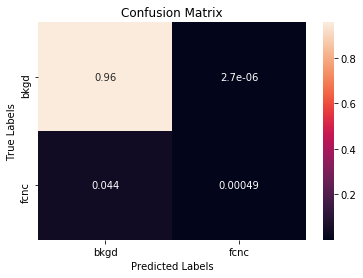

In [5]:
# Confusion Matrix
cm = confusion_matrix(y_val.values, y_preds.round(), normalize="all")

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.xaxis.set_ticklabels(["bkgd", "fcnc"])
ax.yaxis.set_ticklabels(["bkgd", "fcnc"])
plt.show()

# Monte Carlo Dropout

In [6]:
num_models = 100

mc_preds = []
for _ in tqdm(range(num_models), total=num_models, desc="MCDropout"):
    mc_preds.append(model.predict(X_val.values, batch_size=1024).reshape(-1))

mc_means = np.array(mc_preds).mean(axis=0)
mc_stds = np.array(mc_preds).std(axis=0)
mc_preds = mc_means.round()

MCDropout: 100%|██████████| 100/100 [06:53<00:00,  4.14s/it]


In [7]:
# Accuracy
print("Model Accuracy: ", accuracy_score(y_val.values, mc_means.round()))

Model Accuracy:  0.9562227625151408


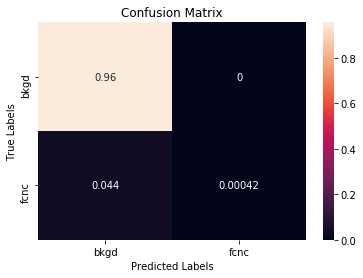

In [8]:
# Confusion Matrix
cm = confusion_matrix(y_val.values, mc_means.round(), normalize="all")

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.xaxis.set_ticklabels(["bkgd", "fcnc"])
ax.yaxis.set_ticklabels(["bkgd", "fcnc"])
plt.show()

## MCDropout by class

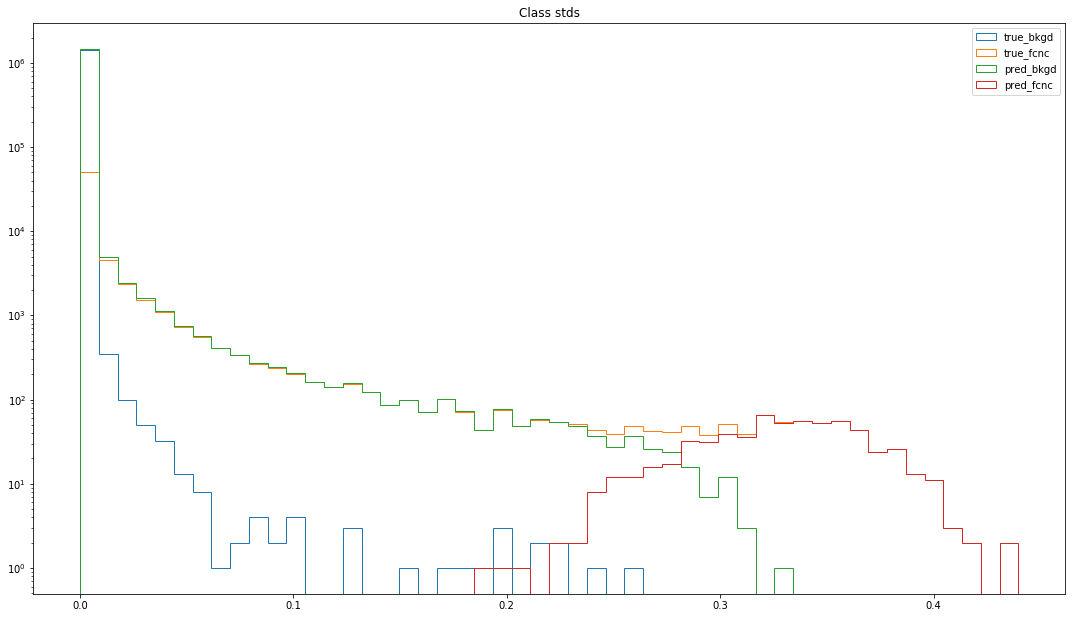

In [9]:
hist_range = (mc_stds.min(), mc_stds.max())

plt.title("Class stds")
plt.gcf().set_size_inches(18.5, 10.5)
plt.hist(mc_stds[y_val == 0], bins=50, range=hist_range, label="true_bkgd", histtype="step")
plt.hist(mc_stds[y_val == 1], bins=50, range=hist_range, label="true_fcnc", histtype="step")
plt.hist(mc_stds[mc_preds == 0], bins=50, range=hist_range, label="pred_bkgd", histtype="step")
plt.hist(mc_stds[mc_preds == 1], bins=50, range=hist_range, label="pred_fcnc", histtype="step")
plt.yscale("log")
plt.legend()
plt.show()

## MCDropout by sample

In [10]:
sample_list = glob("data/dileptonic/*.csv")
sample_list += glob("data/FCNC/*.h5")
sample_list = [s.split('/')[-1].split('.')[0] for s in sample_list]
sample_dict = {sample: mc_stds[val_samples==sample] for sample in sample_list}

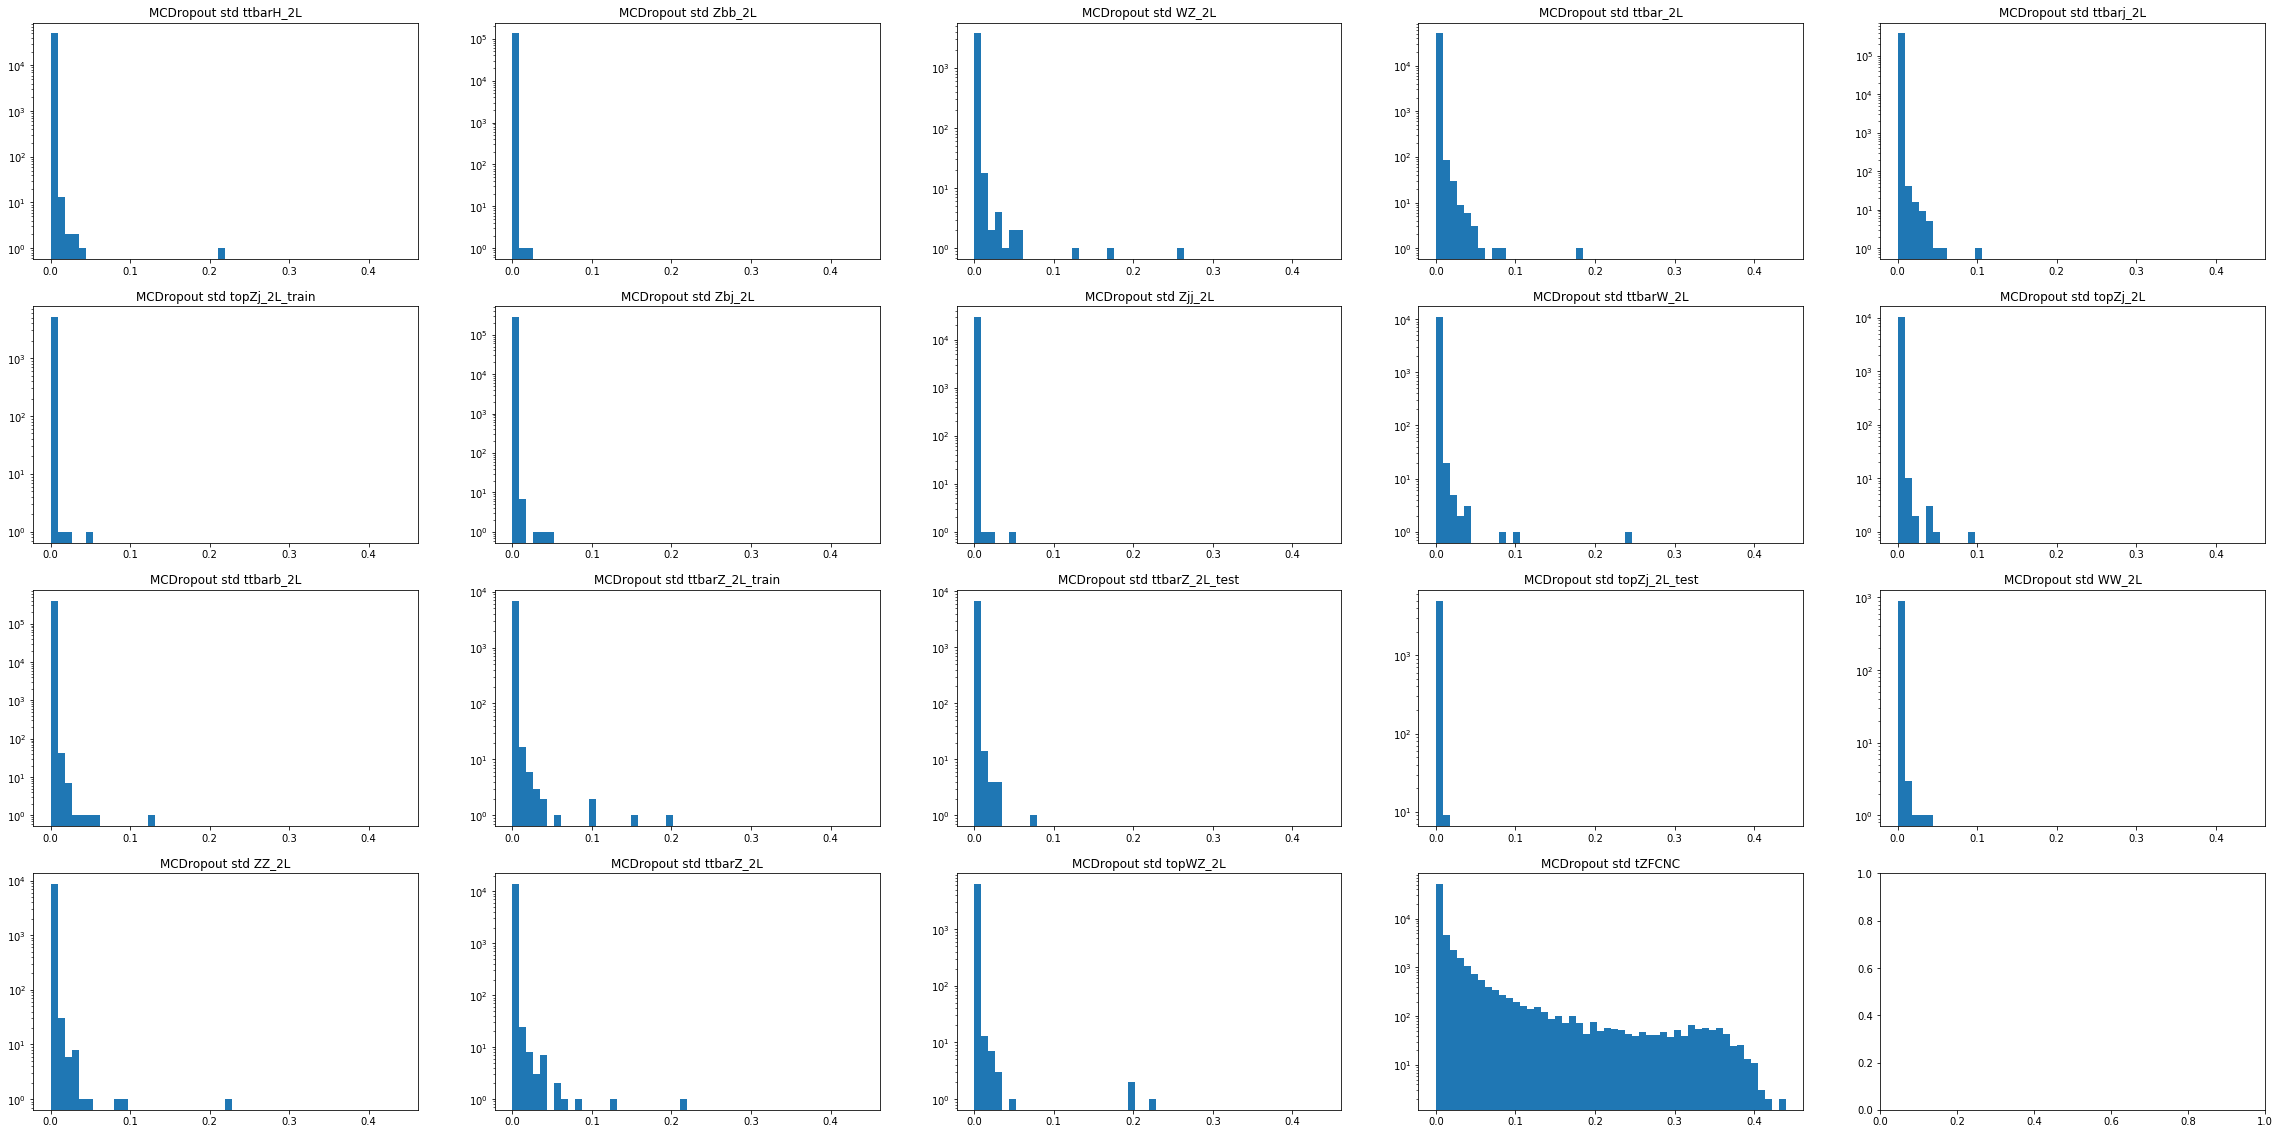

In [11]:
# Variáveis de ajuste dos plots
num_cols, bins = 5, 50

# Criar os plots
num_rows = int(np.ceil((len(sample_dict)) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(40, 20))

# Iterar e plotar cada coluna de dados
for i, sample in enumerate(sample_dict):
    # Dar plot aos dados
    row, col = int(i/num_cols), i%num_cols
    axs[row, col].set_title("MCDropout std " + sample)
    axs[row, col].hist(sample_dict[sample], bins=50, range=hist_range)
    axs[row, col].set_yscale("log")
    
plt.show()

# True vs Predicted Distributions

In [12]:
# Add gen weights and labels to X_val again
X_val["gen_weights"] = val_weights
X_val["Label"] = y_val

# Get fcnc and bkgd validation data
fcnc_true = X_val[X_val["Label"] == 1]
bkgd_true = X_val[X_val["Label"] == 0]

# Get model fcnc and bkgd predictions
fcnc_preds = X_val[mc_preds == 1]
bkgd_preds = X_val[mc_preds == 0]

# Remove weights and labels from X_val
X_val.drop(["gen_weights", "Label"], axis=1, inplace=True)

In [29]:
# Select column to plot
column_index = 68
column = fcnc_true.columns[column_index]
print(column)

ScalarHT_HT


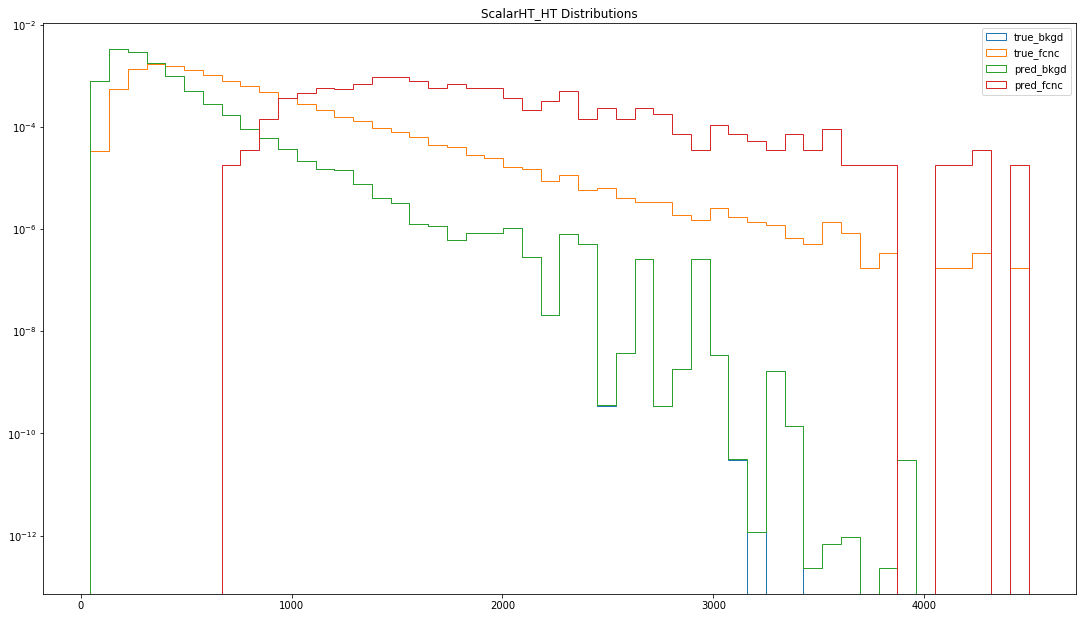

In [30]:
# Define histogram range
hist_min = min(fcnc_true[column].min(), bkgd_true[column].min())
hist_max = max(fcnc_true[column].max(), bkgd_true[column].max())
hist_range = (hist_min, hist_max)

# Plot selected column
plt.title(column + " Distributions")
plt.gcf().set_size_inches(18.5, 10.5)
plt.hist(bkgd_true[column], bins=50, label="true_bkgd", range=hist_range, 
         weights=bkgd_true["gen_weights"], histtype='step', density=True)
plt.hist(fcnc_true[column], bins=50, label="true_fcnc", range=hist_range, 
         weights=fcnc_true["gen_weights"], histtype='step', density=True)
plt.hist(bkgd_preds[column], bins=50, label="pred_bkgd", range=hist_range, 
          weights=bkgd_preds["gen_weights"], histtype='step', density=True)
plt.hist(fcnc_preds[column], bins=50, label="pred_fcnc", range=hist_range, 
         weights=fcnc_preds["gen_weights"], histtype='step', density=True)
plt.yscale("log")
plt.legend()
plt.savefig("plots/" + column + "_distributions.png", dpi=800)
plt.show()